In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import nltk
import spacy

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)
from nltk.tokenize import word_tokenize
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import (GRU, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [6]:
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
import itertools

In [7]:
import text_cleaning_functions as clean

In [8]:
import classification_functions as cf

In [9]:
RANDOM_STATE = 2

In [10]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [11]:
train['text'] = train['text'].str.lower()
test['text'] = test['text'].str.lower()

In [12]:
train['text_clean'] = train['text'].apply(lambda x: clean.remove_URL(x))
train['text_clean'] = train['text_clean'].apply(lambda x: clean.remove_emoji(x))
train['text_clean'] = train['text_clean'].apply(lambda x: clean.remove_html(x))
train['text_clean'] = train['text_clean'].apply(lambda x: clean.remove_punctuation(x))
train['text_clean'] = train['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [13]:
test['text_clean'] = test['text'].apply(lambda x: clean.remove_URL(x))
test['text_clean'] = test['text_clean'].apply(lambda x: clean.remove_emoji(x))
test['text_clean'] = test['text_clean'].apply(lambda x: clean.remove_html(x))
test['text_clean'] = test['text_clean'].apply(lambda x: clean.remove_punctuation(x))
test['text_clean'] = test['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [14]:
nlp = spacy.load('en_core_web_sm')

In [15]:
train['text_lemma'] = train["text_clean"].apply(lambda row: " ".join([w.lemma_ for w in nlp(row)]))
test['text_lemma'] = test["text_clean"].apply(lambda row: " ".join([w.lemma_ for w in nlp(row)]))

In [16]:
train.head()

,id,keyword,location,text,target,text_clean,text_lemma
0,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1,deeds reason earthquake may allah forgive us,deed reason earthquake may allah forgive we
1,4,NaN,NaN,forest fire near la ronge sask. canada,1,forest fire near la ronge sask canada,forest fire near la ronge sask canada
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...,resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,13000 people receive wildfire evacuation order...
4,7,NaN,NaN,just got sent this photo from ruby #alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...,got send photo ruby alaska smoke wildfire pour...


In [17]:
test.head()

,id,keyword,location,text,text_clean,text_lemma
0,0,NaN,NaN,just happened a terrible car crash,happened terrible car crash,happen terrible car crash
1,2,NaN,NaN,"heard about #earthquake is different cities, s...",heard earthquake different cities stay safe ev...,hear earthquake different city stay safe everyone
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese fleeing across str...,forest fire spot pond geese fleeing across str...
3,9,NaN,NaN,apocalypse lighting. #spokane #wildfires,apocalypse lighting spokane wildfires,apocalypse light spokane wildfire
4,11,NaN,NaN,typhoon soudelor kills 28 in china and taiwan,typhoon soudelor kills 28 china taiwan,typhoon soudelor kill 28 china taiwan


In [18]:
embeddings_dictionary = dict()
embedding_dim = 100
glove_file = open('glove.6B.100d.txt')
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [19]:
embeddings_dictionary['happen']

array([ 0.064186,  0.37971 ,  0.74071 , -0.35318 , -0.83723 , -0.30344 ,
       -0.055417,  0.11089 ,  0.50723 , -0.63247 ,  0.17411 ,  0.7864  ,
        0.56312 , -0.027662, -0.098791, -0.29147 , -0.72471 ,  0.98231 ,
       -0.72105 ,  0.63566 ,  0.13122 , -0.21444 , -0.33321 , -0.37086 ,
       -0.26406 , -0.035551, -0.14729 , -0.52021 ,  0.46925 , -0.293   ,
       -0.36627 ,  0.37389 ,  0.33543 , -0.48104 , -0.3273  ,  0.24107 ,
       -0.35336 , -0.13096 ,  0.2525  , -0.91707 , -0.16497 ,  0.34567 ,
       -0.34418 , -0.51686 , -0.65922 , -0.37793 ,  0.79393 , -0.28668 ,
       -0.59818 , -1.4882  ,  0.37955 , -0.21487 , -0.030965,  0.42759 ,
        0.30079 , -1.7414  , -0.16068 ,  0.63717 ,  1.0687  ,  0.5326  ,
       -0.84729 ,  1.3929  , -0.536   , -0.66913 ,  1.0102  ,  0.83339 ,
        0.33661 ,  0.35852 , -0.23342 , -0.33449 ,  0.2705  , -0.8788  ,
       -0.057503, -0.2509  ,  0.87193 , -0.23806 ,  0.16565 , -0.40921 ,
       -0.16265 ,  0.3457  ,  0.39411 , -0.45558 , 

In [32]:
train_1 = train.text_lemma.values
test_1 = test.text_lemma.values
sentiments = train.target.values

In [33]:
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

In [34]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_1)
vocab_length = len(word_tokenizer.word_index) + 1

In [35]:
longest_train = max(train_1, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))
padded_sentences = pad_sequences(embed(train_1), length_long_sentence, padding='post')
test_sentences = pad_sequences(embed(test_1), length_long_sentence, padding='post')

In [36]:
embedding_matrix = np.zeros((vocab_length, embedding_dim))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [37]:
X_train, X_test, y_train, y_test = train_test_split(padded_sentences, sentiments, 
                                                    test_size=0.2, random_state = RANDOM_STATE)

In [38]:
X_train.shape

(6090, 24)

In [39]:
X_test.shape

(1523, 24)

In [40]:
y_train.shape

(6090,)

In [41]:
y_test.shape

(1523,)

In [55]:
BATCH_SIZE = 24
EPOCHS = 3
LAYERS = [length_long_sentence, length_long_sentence]

In [56]:
model = Sequential()
model.add(Embedding(input_dim=embedding_matrix.shape[0], 
                    output_dim=embedding_matrix.shape[1], 
                    weights = [embedding_matrix], 
                    input_length=length_long_sentence))
model.add(Bidirectional(GRU(LAYERS[0], return_sequences = True,
                            dropout = 0.2, recurrent_dropout = 0.2)))
model.add(GlobalMaxPool1D())
model.add(Dense(LAYERS[1], activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [57]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 24, 100)           1571000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 24, 48)            18144     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 48)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 24)                1176      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24)                96        
_________________________________________________________________
dropout_2 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [58]:
history = model.fit(X_train, 
                    y_train, 
                    epochs = EPOCHS, 
                    batch_size = BATCH_SIZE, 
                    validation_data = (X_test, y_test), 
                    verbose = 1)

Epoch 1/3
254/254 [==============================] - 17s 43ms/step - loss: 0.6253 - accuracy: 0.6631 - val_loss: 0.4672 - val_accuracy: 0.8004
Epoch 2/3
254/254 [==============================] - 10s 41ms/step - loss: 0.4465 - accuracy: 0.7985 - val_loss: 0.4190 - val_accuracy: 0.8175
Epoch 3/3
254/254 [==============================] - 10s 39ms/step - loss: 0.3954 - accuracy: 0.8276 - val_loss: 0.4195 - val_accuracy: 0.8148


In [59]:
final_loss, final_acc = model.evaluate(X_test, y_test, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

Final loss: 0.419478, final accuracy: 0.814839


In [60]:
# Predict the values from the validation dataset
y_pred = model.predict_classes(X_test)

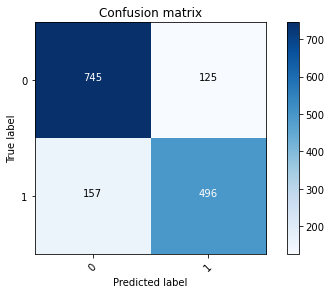

In [61]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred) 
# plot the confusion matrix
cf.plot_confusion_matrix(confusion_mtx, classes = range(2))

In [62]:
print(history.history.keys())
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


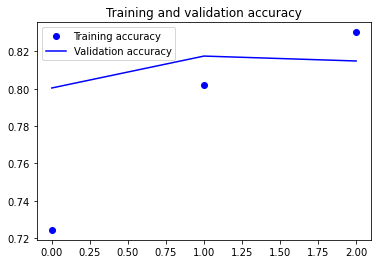

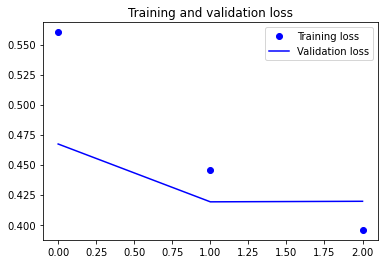

In [63]:
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [64]:
cf.metrics(y_pred, y_test)

F1-score:  0.7786499215070645
Precision:  0.7595712098009189
Recall:  0.7987117552334944
Acuracy:  0.81483913328956
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.83      0.84       902
           1       0.76      0.80      0.78       621

    accuracy                           0.81      1523
   macro avg       0.81      0.81      0.81      1523
weighted avg       0.82      0.81      0.82      1523



In [65]:
submission = pd.read_csv('sample_submission.csv')
submission['target'] = model.predict_classes(test_sentences)

In [66]:
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [67]:
submission.to_csv("basic_gru_lemma.csv", index=False)

In [73]:
BATCH_SIZE = 16
EPOCHS = 2
LAYERS = [length_long_sentence, length_long_sentence]

In [74]:
model = Sequential()
model.add(Embedding(input_dim=embedding_matrix.shape[0], 
                    output_dim=embedding_matrix.shape[1], 
                    weights = [embedding_matrix], 
                    input_length=length_long_sentence))
model.add(Bidirectional(GRU(LAYERS[0], return_sequences = True,
                            dropout = 0.2, recurrent_dropout = 0.2)))
model.add(GlobalMaxPool1D())
model.add(Dense(LAYERS[1], activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [75]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 24, 100)           1571000   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 24, 48)            18144     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 48)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 24)                1176      
_________________________________________________________________
batch_normalization_4 (Batch (None, 24)                96        
_________________________________________________________________
dropout_4 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [76]:
history = model.fit(X_train, 
                    y_train, 
                    epochs = EPOCHS, 
                    batch_size = BATCH_SIZE, 
                    validation_data = (X_test, y_test), 
                    verbose = 1)

Epoch 1/2
381/381 [==============================] - 22s 43ms/step - loss: 0.6797 - accuracy: 0.6185 - val_loss: 0.5117 - val_accuracy: 0.7794
Epoch 2/2
381/381 [==============================] - 13s 34ms/step - loss: 0.4710 - accuracy: 0.7876 - val_loss: 0.4534 - val_accuracy: 0.8155


In [77]:
final_loss, final_acc = model.evaluate(X_test, y_test, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

Final loss: 0.453354, final accuracy: 0.815496


In [78]:
# Predict the values from the validation dataset
y_pred = model.predict_classes(X_test)

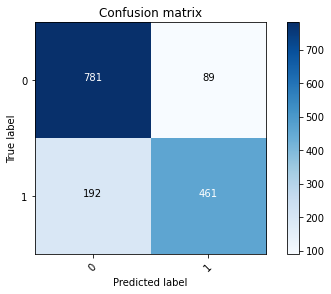

In [79]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred) 
# plot the confusion matrix
cf.plot_confusion_matrix(confusion_mtx, classes = range(2))

In [80]:
print(history.history.keys())
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


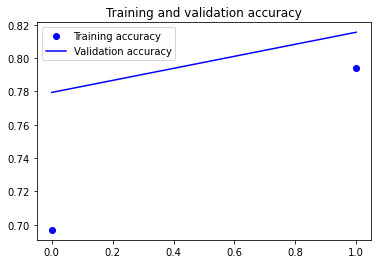

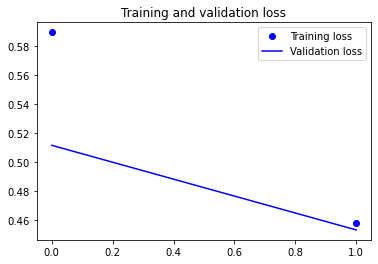

In [81]:
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [82]:
cf.metrics(y_pred, y_test)

F1-score:  0.766417290108063
Precision:  0.7059724349157733
Recall:  0.8381818181818181
Acuracy:  0.8154957321076822
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.80      0.85       973
           1       0.71      0.84      0.77       550

    accuracy                           0.82      1523
   macro avg       0.80      0.82      0.81      1523
weighted avg       0.83      0.82      0.82      1523



In [83]:
submission = pd.read_csv('sample_submission.csv')
submission['target'] = model.predict_classes(test_sentences)

In [84]:
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [85]:
submission.to_csv("basic_gru_lemma2.csv", index=False)